Our discussion is limited to the methods and models we apply and does not include an in-depth discussion of pyMAISE. For an in-depth tutorial, refer to the [MIT Reactor](https://pymaise.readthedocs.io/en/stable/examples/mit_reactor.html) notebook. For information on the pyMAISE methods used, refer to the [pyMAISE API reference documentation](https://pymaise.readthedocs.io/en/stable/pymaiseapi/index.html).

# BWR Micro Core

**Inputs** 

- `PSZ`: Fuel bundle region Power Shaping Zone (PSZ).
- `DOM`:  Fuel bundle region Dominant zone (DOM).
- `vanA`: Fuel bundle region vanishing zone A (VANA).
- `vanB`: Fuel bundle region vanishing zone B (VANB)
- `subcool`: Represents moderator inlet conditions. Core inlet subcooling interpreted to be at the steam dome pressure (i.e., not core-averaged pressure). The input value for subcooling will automatically be increased to account for this fact. (Btu/lb)?
- `CRD`: Defines the position of all control rod groups (banks).
- `flow_rate`: Defines essential global design data for rated coolant mass flux for the active core, $\frac{kg}{(cm^{2}-hr)}$. Coolant   mass flux equals active core flow divided by core cross-section area. Core cross-section area is DXA 2 times the number of assemblies.
- `power_density`: Defines essential global design data for rated power density using cold dimensions, $(\frac{kw}{liter})$.
- `VFNGAP`: Defines the ratio of narrow water gap width to the sum of the narrow and wide water gap widths.

**Output**

- `K-eff`:  Reactivity coefficient k-effective, the effective neutron multiplication factor.
- `Max3Pin`: Maximum planar-averaged pin power peaking factor.
- `Max4Pin`: maximum pin-power peaking factor, $F_{q}$, (which includes axial intranodal peaking).
- `F-delta-H`: Ratio of max-to-average enthalpy rise in a channel.
- `Max-Fxy`: Maximum radial pin-power peaking factor.

    The data set consists of 2000 data points with 9 inputs and 5 outputs. This data set was constructed through uniform and normal sampling of the 9 input parameters for a boiling water reactor (BWR) micro-core. These samples were then used to solve for reactor characteristic changes in heat distribution and neutron flux. This BWR micro-core consists of 4 radially and axially heterogenous assemblies of the same type constructed in a 2x2 grid with a control blade placed in the center. A single assembly composition can be seen in the figure below. A single assembly was brocken into seven zones where each zones 2D radial cross sectional information was constructed using CASMO-4. These cross sectional libraries were then processed through CMSLINK for SIMULATE-3 to interpret. The core geometry and physics was implemented and modeled using SIMULATE-3 [[RFS21]](https://pymaise.readthedocs.io/en/stable/index.html#id3).
    
Note: The reference uses the same model as this example, but the data generated is not the same as the paper.

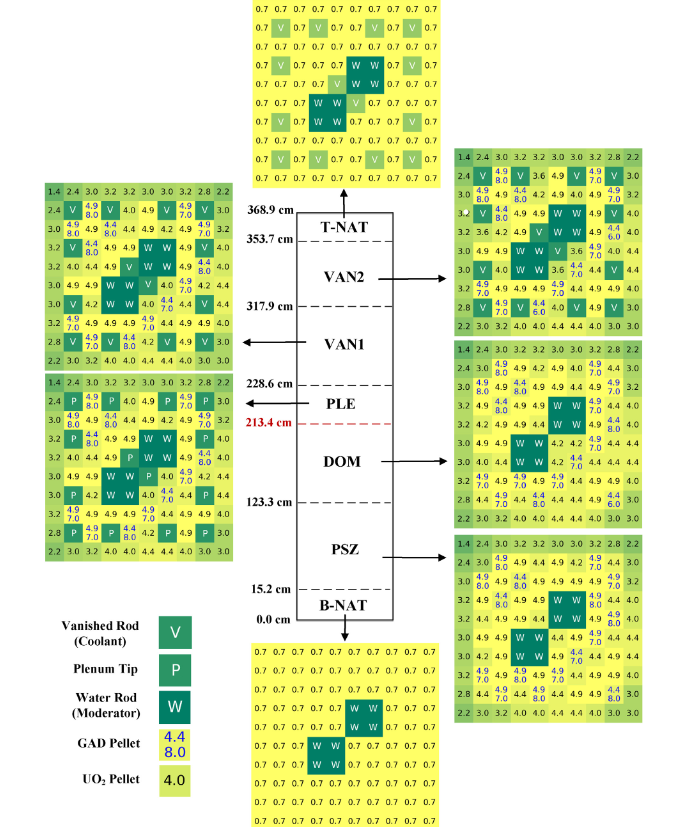

TO start off pyMAISE the general packages are used.

In [65]:
from pyMAISE.datasets import load_BWR
from pyMAISE.preprocessing import correlation_matrix, train_test_split, scale_data
import pyMAISE as mai

import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler

# Plot settings
matplotlib_settings = {
    "font.size": 12,
    "legend.fontsize": 11,
    "figure.figsize": (8, 8)
}
plt.rcParams.update(**matplotlib_settings)

## pyMAISE Initialization

In [38]:
global_settings = mai.init(
    problem_type=mai.ProblemType.REGRESSION,   # Define a regression problem
    cuda_visible_devices="-1"                  # Use CPU only
)
data, inputs, outputs = load_BWR()

The BWR micro reactor data set has 9 inputs


In [39]:
inputs

<xarray.DataArray (index: 2000, variable: 9)>
array([[1.20334e+02, 2.16336e+02, 3.38763e+02, ..., 2.50161e+02,
        6.62500e+01, 2.22000e-01],
       [1.37906e+02, 1.98764e+02, 3.49531e+02, ..., 2.53792e+02,
        6.60440e+01, 3.93000e-01],
       [1.31235e+02, 2.05435e+02, 3.17283e+02, ..., 2.55631e+02,
        6.58390e+01, 4.32000e-01],
       ...,
       [1.11014e+02, 2.25656e+02, 3.04242e+02, ..., 2.47461e+02,
        6.27380e+01, 3.46000e-01],
       [1.10651e+02, 2.26019e+02, 3.11476e+02, ..., 2.54682e+02,
        6.57490e+01, 3.55000e-01],
       [1.17517e+02, 2.19153e+02, 3.46947e+02, ..., 2.50026e+02,
        6.54060e+01, 2.35000e-01]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 ... 1993 1994 1995 1996 1997 1998 1999
  * variable  (variable) object 'PSZ' 'DOM' 'vanA' ... 'power_density' 'VFNGAP'

and 5 outputs with 2000 samples

In [40]:
outputs

<xarray.DataArray (index: 2000, variable: 5)>
array([[0.95455, 5.105  , 5.303  , 1.861  , 1.899  ],
       [0.98576, 2.839  , 2.904  , 1.436  , 1.816  ],
       [0.95237, 5.161  , 5.43   , 1.846  , 1.903  ],
       ...,
       [0.99524, 2.471  , 2.54   , 1.261  , 1.842  ],
       [0.70601, 7.199  , 7.752  , 1.51   , 1.854  ],
       [0.99079, 2.507  , 2.595  , 1.326  , 1.831  ]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 ... 1993 1994 1995 1996 1997 1998 1999
  * variable  (variable) object 'K-eff' 'Max3Pin' ... 'F-delta-H' 'Max-Fxy'

To better understand the data here is a correlation matrix of the data.

(<Figure size 800x800 with 2 Axes>, <AxesSubplot:>)

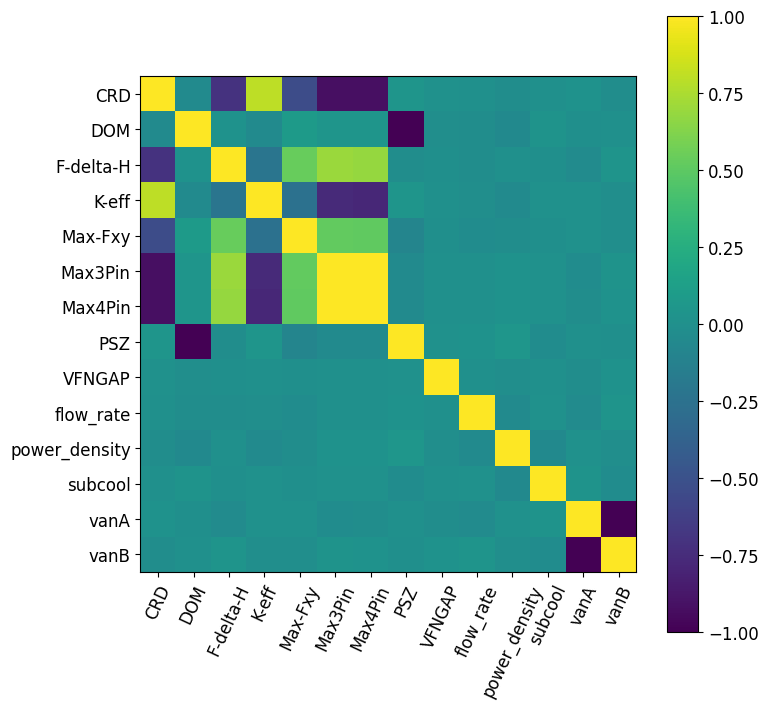

In [41]:
correlation_matrix(data)

As expected there is a strong negative correlation between control rod position (CRD) and the peaking factors. There is also a strong positive correlation between control rod position and k effective.

Prior to model training the data is min-max scaled to make each feature's effect size is comparable. Additionally, this can improve the performance of some models.


In [42]:
xtrain, xtest, ytrain, ytest = train_test_split(data=[inputs, outputs], test_size=0.3)
xtrain, xtest, xscaler = scale_data(xtrain, xtest, scaler=MinMaxScaler())
ytrain, ytest, yscaler = scale_data(ytrain, ytest, scaler=MinMaxScaler())

## Model Initialization
Given this data set has a multi-dimensional output we will compare the performance of 7 machine learning (ML) models:

- Linear regression: `Linear`,
- Lasso regression: `Lasso`,
- Decision tree regression: `DT`,
- Random forest regression: `RF`,
- K-nearest neighbors regression: `KN`,
- Sequential dense neural networks: `FNN`.

For hyperparameter tuing, we initialize all classical models as scikit-learn defaults. For the FNN we define input and output layers with possible dropout layers. These layers include hyperparameter tuning of their number of nodes, use of sublayer, and the rate of dropout. The dense hidden layers include tuning of their depth.

In [43]:
model_settings = {
    "models": ["Linear", "Lasso", "DT", "RF", "KN", "FNN"],
    "FNN": {
        "structural_params": {
            "Dense_input": {
                "units": mai.Int(min_value=50, max_value=600),
                "input_dim": xtrain.shape[-1],
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout", "None"]),
                "Dropout": {
                    "rate": mai.Float(min_value=0.4, max_value=0.6),
                },
            },
            "Dense_hidden": {
                "num_layers": mai.Int(min_value=0, max_value=5),
                "units": mai.Int(min_value=25, max_value=350),
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout_hidden", "None"]),
                "Dropout_hidden": {
                    "rate": mai.Float(min_value=0.2, max_value=0.6),
                },
            },
            "Dense_output": {
                "units": ytrain.shape[-1],
                "activation": "linear",
                "kernel_initializer": "normal",
            },
        },
        "optimizer": "Adam",
        "Adam": {
            "learning_rate": mai.Float(min_value=1e-5, max_value=0.001),
        },
        "compile_params": {
            "loss": "mean_absolute_error",
            "metrics": ["mean_absolute_error"],
        },
        "fitting_params": {
            "batch_size": mai.Choice([8, 16, 32, 64]),
            "epochs": 100,
            "validation_split": 0.15,
        },
    },
}
tuner = mai.Tuner(xtrain, ytrain, model_settings=model_settings)

## Hyper-parameter Tuning

We use random search with 200 iterations and 5 cross validation splits (1000 fits per model) for the classical models. The hyperparameter search space is defined for all but linear regression in which the default scikit-learn configuration will be tested. For the FNN we use Bayesian search with 150 iterations and 5 cross validation splits (750 fits total). This offers possible convergence on an optimal configuration without taking an excessive amount of time. Classical models tend to be simpler than neural networks so a large amount of random search iterations are possible.

In [44]:
random_search_spaces = {
    "Lasso": {
        "alpha": uniform(loc=0.0001, scale=0.0099), # 0.0001 - 0.01
    },
    "DT": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "RF": {
        "n_estimators": randint(low=50, high=200), # 50 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
    },
    "KN": {
        "n_neighbors": randint(low=1, high=20), # 1 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=1, high=30), # 1 - 30
        "p": randint(low=1, high=10), # 1 - 10
    },
}
start = time.time()
random_search_configs = tuner.random_search(
    param_spaces=random_search_spaces, 
    n_iter=200, 
    cv=5,
)
bayesian_search_configs = tuner.nn_bayesian_search(
    objective="r2_score",
    max_trials=150,
    cv=5,
)
print("Hyperparameter tuning took " + str((time.time() - start) / 60) + " minutes to process.")

Trial 150 Complete [00h 01m 16s]
r2_score: 0.559413416811373

Best r2_score So Far: 0.6606018383372637
Total elapsed time: 02h 02m 14s
Hyperparameter tuning took 170.4734009583791 minutes to process.


With the conclusion of training we can see training results for each iteration using the convergence_plot function. For example here is Bayesian search of neural networks:

(0.0, 1.0)

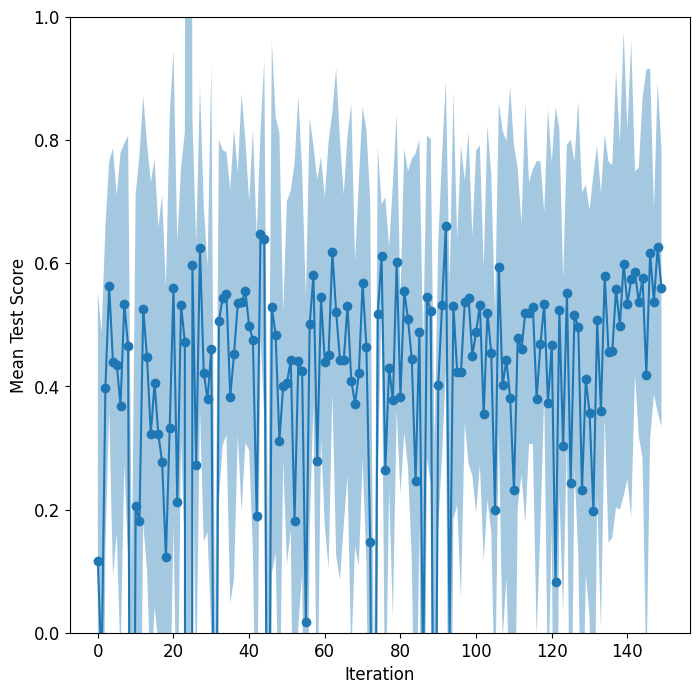

In [45]:
ax = tuner.convergence_plot(model_types="FNN")
ax.set_ylim([0, 1])

Fewer than 20 iterations were required to converge to the optimal parameter configurations. Increasing iteration from there diverge then re-converge on a similiar error.

## Model Post-processing

With the models tuned and the top `num_configs_saved` saved, we can now pass these models to the `PostProcessor` for model comparison and analysis. We will increase the `epochs` of the `nn` models for better performance.

In [46]:
postprocessor = mai.PostProcessor(
    data=(xtrain, xtest, ytrain, ytest), 
    model_configs=[random_search_configs, bayesian_search_configs], 
    new_model_settings={
        "FNN": {"epochs": 500},
    },
    yscaler=yscaler,
)

To compare the performance of these models we will compute 4 metrics for both the training and testing data: 

- mean squared error `MSE` $=\frac{1}{n}\sum^n_{i = 1}(y_i - \hat{y_i})^2$, 
- root mean squared error `RMSE` $=\sqrt{\frac{1}{n}\sum^n_{i = 1}(y_i - \hat{y_i})^2}$,
- mean absolute error `MAE` = $=\frac{1}{n}\sum^n_{i = 1}|y_i - \hat{y_i}|$,
- and r-squared `R2` $=1 - \frac{\sum^n_{i = 1}(y_i - \hat{y_i})^2}{\sum^n_{i = 1}(y_i - \bar{y_i})^2}$,

where $y$ is the actual outcome, $\bar{y}$ is the average outcome, $\hat{y}$ is the model predicted outcome, and $n$ is the number of observations. The averaged performance metrics are shown below.

In [47]:
postprocessor.metrics()

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
6,DT,"{'max_depth': 39, 'max_features': None, 'min_s...",0.994918,0.019145,0.003455,0.058776,0.973112,0.046122,0.028649,0.169259
9,DT,"{'max_depth': 33, 'max_features': None, 'min_s...",0.997611,0.013620,0.002113,0.045968,0.971240,0.046542,0.032501,0.180280
11,RF,"{'criterion': 'squared_error', 'max_features':...",0.987458,0.031625,0.010121,0.100605,0.971223,0.054596,0.038322,0.195761
13,RF,"{'criterion': 'poisson', 'max_features': None,...",0.987077,0.030888,0.009804,0.099013,0.970589,0.054416,0.037467,0.193563
12,RF,"{'criterion': 'squared_error', 'max_features':...",0.987492,0.031403,0.009884,0.099418,0.969979,0.054494,0.039965,0.199913
14,RF,"{'criterion': 'poisson', 'max_features': None,...",0.983274,0.035436,0.012677,0.112590,0.967374,0.057647,0.040663,0.201649
15,RF,"{'criterion': 'poisson', 'max_features': None,...",0.980262,0.038682,0.014941,0.122232,0.965079,0.059645,0.042285,0.205634
8,DT,"{'max_depth': 15, 'max_features': None, 'min_s...",0.986736,0.032243,0.012605,0.112273,0.961590,0.057121,0.056542,0.237785
7,DT,"{'max_depth': 41, 'max_features': None, 'min_s...",0.987337,0.030857,0.011545,0.107446,0.960136,0.058180,0.060057,0.245065
10,DT,"{'max_depth': 44, 'max_features': None, 'min_s...",0.981794,0.038031,0.014841,0.121824,0.959987,0.060545,0.055781,0.236181


Given the top performing models are `decission tree (DT)` and `random forest (RF)` this data set's outputs are non-linear with their inputs. The `FNN` models performed well, but not amazing. Further analysis will be done later to see which outputs metric brought the values down when averaged. Performance quickly drops off with `Linear`, `Lasso`, and `KN`. We can look specifically at the performance for each output:

In [48]:
postprocessor.metrics(y="K-eff")

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
23,FNN,"{'Dense_input_0_units': 455, 'Dense_input_0_su...",0.996201,0.002991,0.000030,0.005487,0.993373,0.003826,0.000052,0.007190
11,RF,"{'criterion': 'squared_error', 'max_features':...",0.997094,0.002431,0.000023,0.004799,0.991916,0.003754,0.000063,0.007941
12,RF,"{'criterion': 'squared_error', 'max_features':...",0.997128,0.002385,0.000023,0.004770,0.991568,0.003739,0.000066,0.008111
14,RF,"{'criterion': 'poisson', 'max_features': None,...",0.996843,0.002576,0.000025,0.005002,0.990938,0.003994,0.000071,0.008408
25,FNN,"{'Dense_input_0_units': 596, 'Dense_input_0_su...",0.992650,0.004906,0.000058,0.007631,0.990849,0.005344,0.000071,0.008449
13,RF,"{'criterion': 'poisson', 'max_features': None,...",0.997495,0.002306,0.000020,0.004455,0.990802,0.003917,0.000072,0.008471
6,DT,"{'max_depth': 39, 'max_features': None, 'min_s...",0.999142,0.001551,0.000007,0.002607,0.990157,0.003532,0.000077,0.008763
15,RF,"{'criterion': 'poisson', 'max_features': None,...",0.996114,0.002861,0.000031,0.005549,0.989945,0.004224,0.000078,0.008857
9,DT,"{'max_depth': 33, 'max_features': None, 'min_s...",0.999542,0.001124,0.000004,0.001905,0.989546,0.003665,0.000082,0.009031
22,FNN,"{'Dense_input_0_units': 198, 'Dense_input_0_su...",0.989633,0.005963,0.000082,0.009063,0.989063,0.006128,0.000085,0.009237


For K-eff, random forest out performed decission tree. Knn seems to be overfit and linear did poorly which is expected for a non-linear data set. Neural Networks performed the best.

In [49]:
postprocessor.metrics(y="Max3Pin")

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
6,DT,"{'max_depth': 39, 'max_features': None, 'min_s...",0.996953,0.041566,0.007728,0.087909,0.972041,0.101180,0.067053,0.258946
9,DT,"{'max_depth': 33, 'max_features': None, 'min_s...",0.998136,0.029933,0.004729,0.068770,0.968357,0.102665,0.075887,0.275477
23,FNN,"{'Dense_input_0_units': 455, 'Dense_input_0_su...",0.984090,0.072920,0.040356,0.200888,0.967670,0.106207,0.077535,0.278451
13,RF,"{'criterion': 'poisson', 'max_features': None,...",0.991223,0.066057,0.022262,0.149206,0.965249,0.117421,0.083341,0.288688
11,RF,"{'criterion': 'squared_error', 'max_features':...",0.990954,0.068586,0.022946,0.151479,0.964559,0.118604,0.084996,0.291541
12,RF,"{'criterion': 'squared_error', 'max_features':...",0.991122,0.068040,0.022520,0.150067,0.963047,0.118481,0.088622,0.297695
14,RF,"{'criterion': 'poisson', 'max_features': None,...",0.988652,0.076266,0.028784,0.169659,0.962413,0.124696,0.090142,0.300236
15,RF,"{'criterion': 'poisson', 'max_features': None,...",0.986508,0.083482,0.034222,0.184992,0.960836,0.128905,0.093925,0.306473
21,FNN,"{'Dense_input_0_units': 329, 'Dense_input_0_su...",0.975126,0.104132,0.063092,0.251180,0.951861,0.127809,0.115449,0.339777
22,FNN,"{'Dense_input_0_units': 198, 'Dense_input_0_su...",0.961353,0.135112,0.098028,0.313094,0.948207,0.150015,0.124212,0.352437


Max3Pin had similiar performance to K-eff. Neural nets did slightly poorer, but still produced the best results.

In [50]:
postprocessor.metrics(y="Max4Pin")

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
6,DT,"{'max_depth': 39, 'max_features': None, 'min_s...",0.996818,0.044327,0.009371,0.096802,0.972963,0.107875,0.075107,0.274056
9,DT,"{'max_depth': 33, 'max_features': None, 'min_s...",0.998050,0.031359,0.005742,0.075774,0.969241,0.108099,0.085446,0.292311
23,FNN,"{'Dense_input_0_units': 455, 'Dense_input_0_su...",0.983889,0.073957,0.047444,0.217817,0.966217,0.109750,0.093845,0.306341
13,RF,"{'criterion': 'poisson', 'max_features': None,...",0.991047,0.070794,0.026365,0.162374,0.962910,0.129076,0.103031,0.320985
11,RF,"{'criterion': 'squared_error', 'max_features':...",0.990724,0.073576,0.027316,0.165276,0.961894,0.131430,0.105853,0.325351
12,RF,"{'criterion': 'squared_error', 'max_features':...",0.990981,0.073120,0.026559,0.162969,0.960239,0.131174,0.110452,0.332342
14,RF,"{'criterion': 'poisson', 'max_features': None,...",0.988414,0.081323,0.034117,0.184709,0.959609,0.136772,0.112200,0.334963
15,RF,"{'criterion': 'poisson', 'max_features': None,...",0.986446,0.088333,0.039914,0.199786,0.958074,0.141140,0.116466,0.341271
21,FNN,"{'Dense_input_0_units': 329, 'Dense_input_0_su...",0.975081,0.104980,0.073380,0.270887,0.950709,0.130221,0.136924,0.370033
22,FNN,"{'Dense_input_0_units': 198, 'Dense_input_0_su...",0.961320,0.143779,0.113904,0.337497,0.945849,0.164645,0.150424,0.387845


Max4Pin results are very similiar to Max3Pin with once again `FNN` doing the best.

In [51]:
postprocessor.metrics(y="F-delta-H")

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
12,RF,"{'criterion': 'squared_error', 'max_features':...",0.994273,0.009065,0.000232,0.015219,0.987745,0.013448,0.000517,0.022747
11,RF,"{'criterion': 'squared_error', 'max_features':...",0.994169,0.009191,0.000236,0.015356,0.987225,0.013632,0.000539,0.023225
21,FNN,"{'Dense_input_0_units': 329, 'Dense_input_0_su...",0.987095,0.014350,0.000522,0.022845,0.984648,0.016568,0.000648,0.025460
14,RF,"{'criterion': 'poisson', 'max_features': None,...",0.991646,0.011281,0.000338,0.018381,0.983204,0.016070,0.000709,0.026631
23,FNN,"{'Dense_input_0_units': 455, 'Dense_input_0_su...",0.988966,0.014678,0.000446,0.021124,0.982888,0.018304,0.000723,0.026880
13,RF,"{'criterion': 'poisson', 'max_features': None,...",0.993079,0.010180,0.000280,0.016730,0.982624,0.015482,0.000734,0.027087
7,DT,"{'max_depth': 41, 'max_features': None, 'min_s...",0.993948,0.008219,0.000245,0.015644,0.982525,0.012917,0.000738,0.027163
15,RF,"{'criterion': 'poisson', 'max_features': None,...",0.990200,0.012479,0.000396,0.019907,0.982358,0.016808,0.000745,0.027293
8,DT,"{'max_depth': 15, 'max_features': None, 'min_s...",0.993459,0.008705,0.000265,0.016264,0.982260,0.013215,0.000749,0.027369
6,DT,"{'max_depth': 39, 'max_features': None, 'min_s...",0.996758,0.005297,0.000131,0.011450,0.979938,0.012767,0.000847,0.029105


F-delta-H also had very good performance in random forest and decision tree with slightly poorer results for neural nets. K nearest neighbors is still overfit.

In [52]:
postprocessor.metrics(y="Max-Fxy")

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
13,RF,"{'criterion': 'poisson', 'max_features': None,...",0.962542,0.005103,0.000090,0.009494,0.951362,0.006188,0.000156,0.012498
9,DT,"{'max_depth': 33, 'max_features': None, 'min_s...",0.994231,0.002085,0.000014,0.003726,0.951157,0.005006,0.000157,0.012525
11,RF,"{'criterion': 'squared_error', 'max_features':...",0.964352,0.004341,0.000086,0.009262,0.950520,0.005559,0.000159,0.012606
6,DT,"{'max_depth': 39, 'max_features': None, 'min_s...",0.984917,0.002981,0.000036,0.006024,0.950462,0.005253,0.000159,0.012614
8,DT,"{'max_depth': 15, 'max_features': None, 'min_s...",0.965425,0.004477,0.000083,0.009121,0.947981,0.005678,0.000167,0.012926
7,DT,"{'max_depth': 41, 'max_features': None, 'min_s...",0.965813,0.004374,0.000082,0.009070,0.947574,0.005685,0.000168,0.012976
12,RF,"{'criterion': 'squared_error', 'max_features':...",0.963956,0.004405,0.000087,0.009313,0.947295,0.005626,0.000169,0.013011
10,DT,"{'max_depth': 44, 'max_features': None, 'min_s...",0.949949,0.005526,0.000120,0.010974,0.942436,0.006382,0.000185,0.013597
14,RF,"{'criterion': 'poisson', 'max_features': None,...",0.950814,0.005735,0.000118,0.010879,0.940703,0.006706,0.000190,0.013800
15,RF,"{'criterion': 'poisson', 'max_features': None,...",0.942042,0.006254,0.000139,0.011809,0.934182,0.007148,0.000211,0.014539


Max-Fxy results differed from the rest. Decission tree had an R2 of 0.97 instead of 0.99 and random forest has similiar results. The big shock is in neural nets where the model performed at an R-squared of about 0.33, which is extremely poor.

Next the best performing models hyperparameters are shown.

In [53]:
for model in ["Lasso", "DT", "RF", "KN", "FNN"]:
    for key, value in postprocessor.get_params(model_type=model).to_dict().items():
        print(f"{key}: {value[0]}")
    print()

Model Types: Lasso
alpha: 0.0004606584490621787

Model Types: DT
max_depth: 33
max_features: None
min_samples_leaf: 2
min_samples_split: 4

Model Types: RF
criterion: poisson
max_features: None
min_samples_leaf: 4
min_samples_split: 8
n_estimators: 52

Model Types: KN
leaf_size: 17
n_neighbors: 7
p: 2
weights: distance

Model Types: FNN
Dense_input_0_units: 467
Dense_input_0_sublayer: Dropout
Dense_input_0_sublayer_Dropout_0_rate: 0.44820663190947696
Dense_hidden_num_layers: 4
Adam_learning_rate: 0.00079695012270146
Dense_hidden_0_units: 220
Dense_hidden_0_sublayer: Dropout_hidden
Dense_hidden_0_sublayer_Dropout_hidden_0_rate: 0.34788954467136024
Dense_hidden_1_units: 189
Dense_hidden_1_sublayer: None
Dense_hidden_1_sublayer_Dropout_hidden_0_rate: 0.3134072264733909
Dense_hidden_2_units: 310
Dense_hidden_2_sublayer: None
Dense_hidden_2_sublayer_Dropout_hidden_0_rate: 0.4116635486809873
batch_size: 16
Dense_hidden_3_units: 138
Dense_hidden_3_sublayer: None
Dense_hidden_3_sublayer_Dropou

To visualize the performance of these models we can use the `diagonal_validation_plot` functions to produce diagonal validation plots. This example will only be look at the `K-eff` output feature.

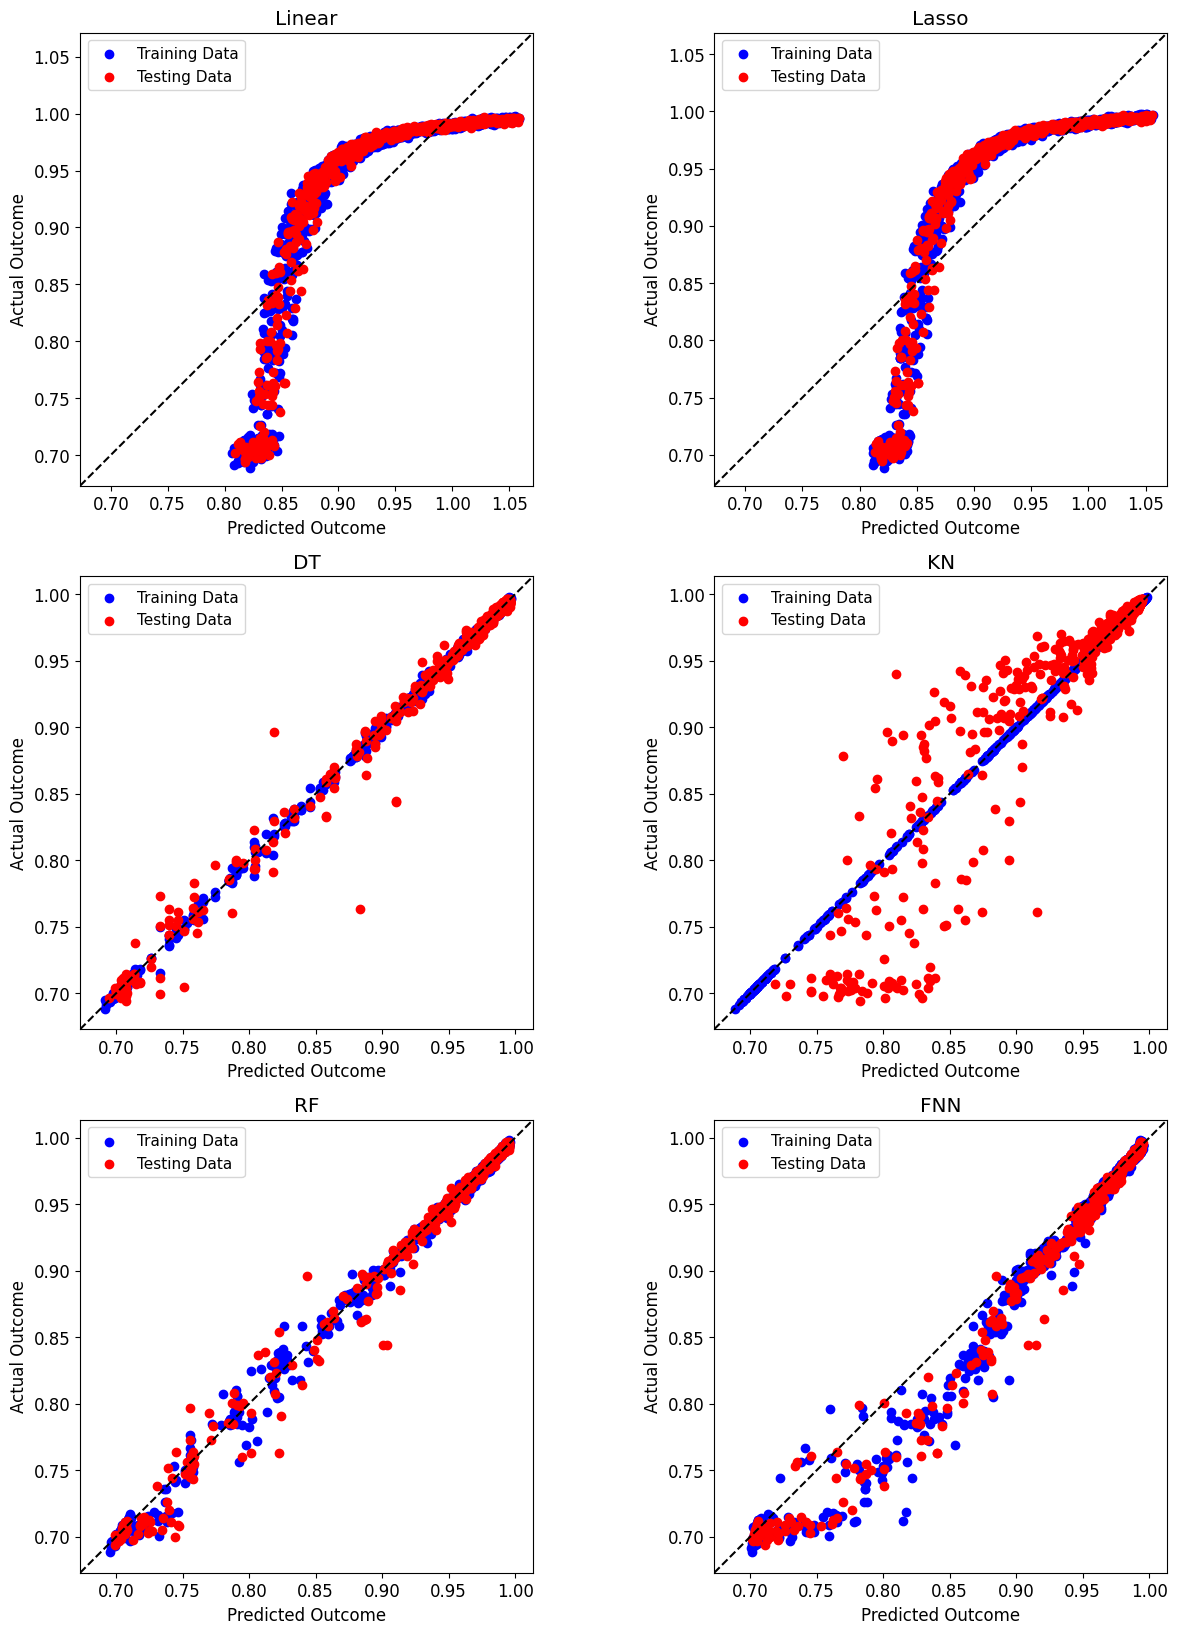

In [56]:
def performance_plot(meth, output):
    models = np.array([["Linear", "Lasso"], ["DT", "KN"], ["RF", "FNN"]])
    fig, axarr = plt.subplots(models.shape[0], models.shape[1], figsize=(15,20))
    for i in range(models.shape[0]):
        for j in range(models.shape[1]):
            plt.sca(axarr[i, j])
            axarr[i, j] = meth(model_type=models[i, j], y=[output])
            axarr[i, j].set_title(models[i, j])


performance_plot(postprocessor.diagonal_validation_plot, "K-eff")

The performance differences between `RF`, `DT`, and `FNN` are minimal and produce the best results. It is apparent  overfitting occures in various degrees for all the models, `KN` being the worst. The predictions of `RF` and `DT` are closely spread along $y=x$ while the `KN` test predictions are over-predicted.

Similarly, the `validation_plot` function produces validation plots that show the absolute relative error for each prediction.

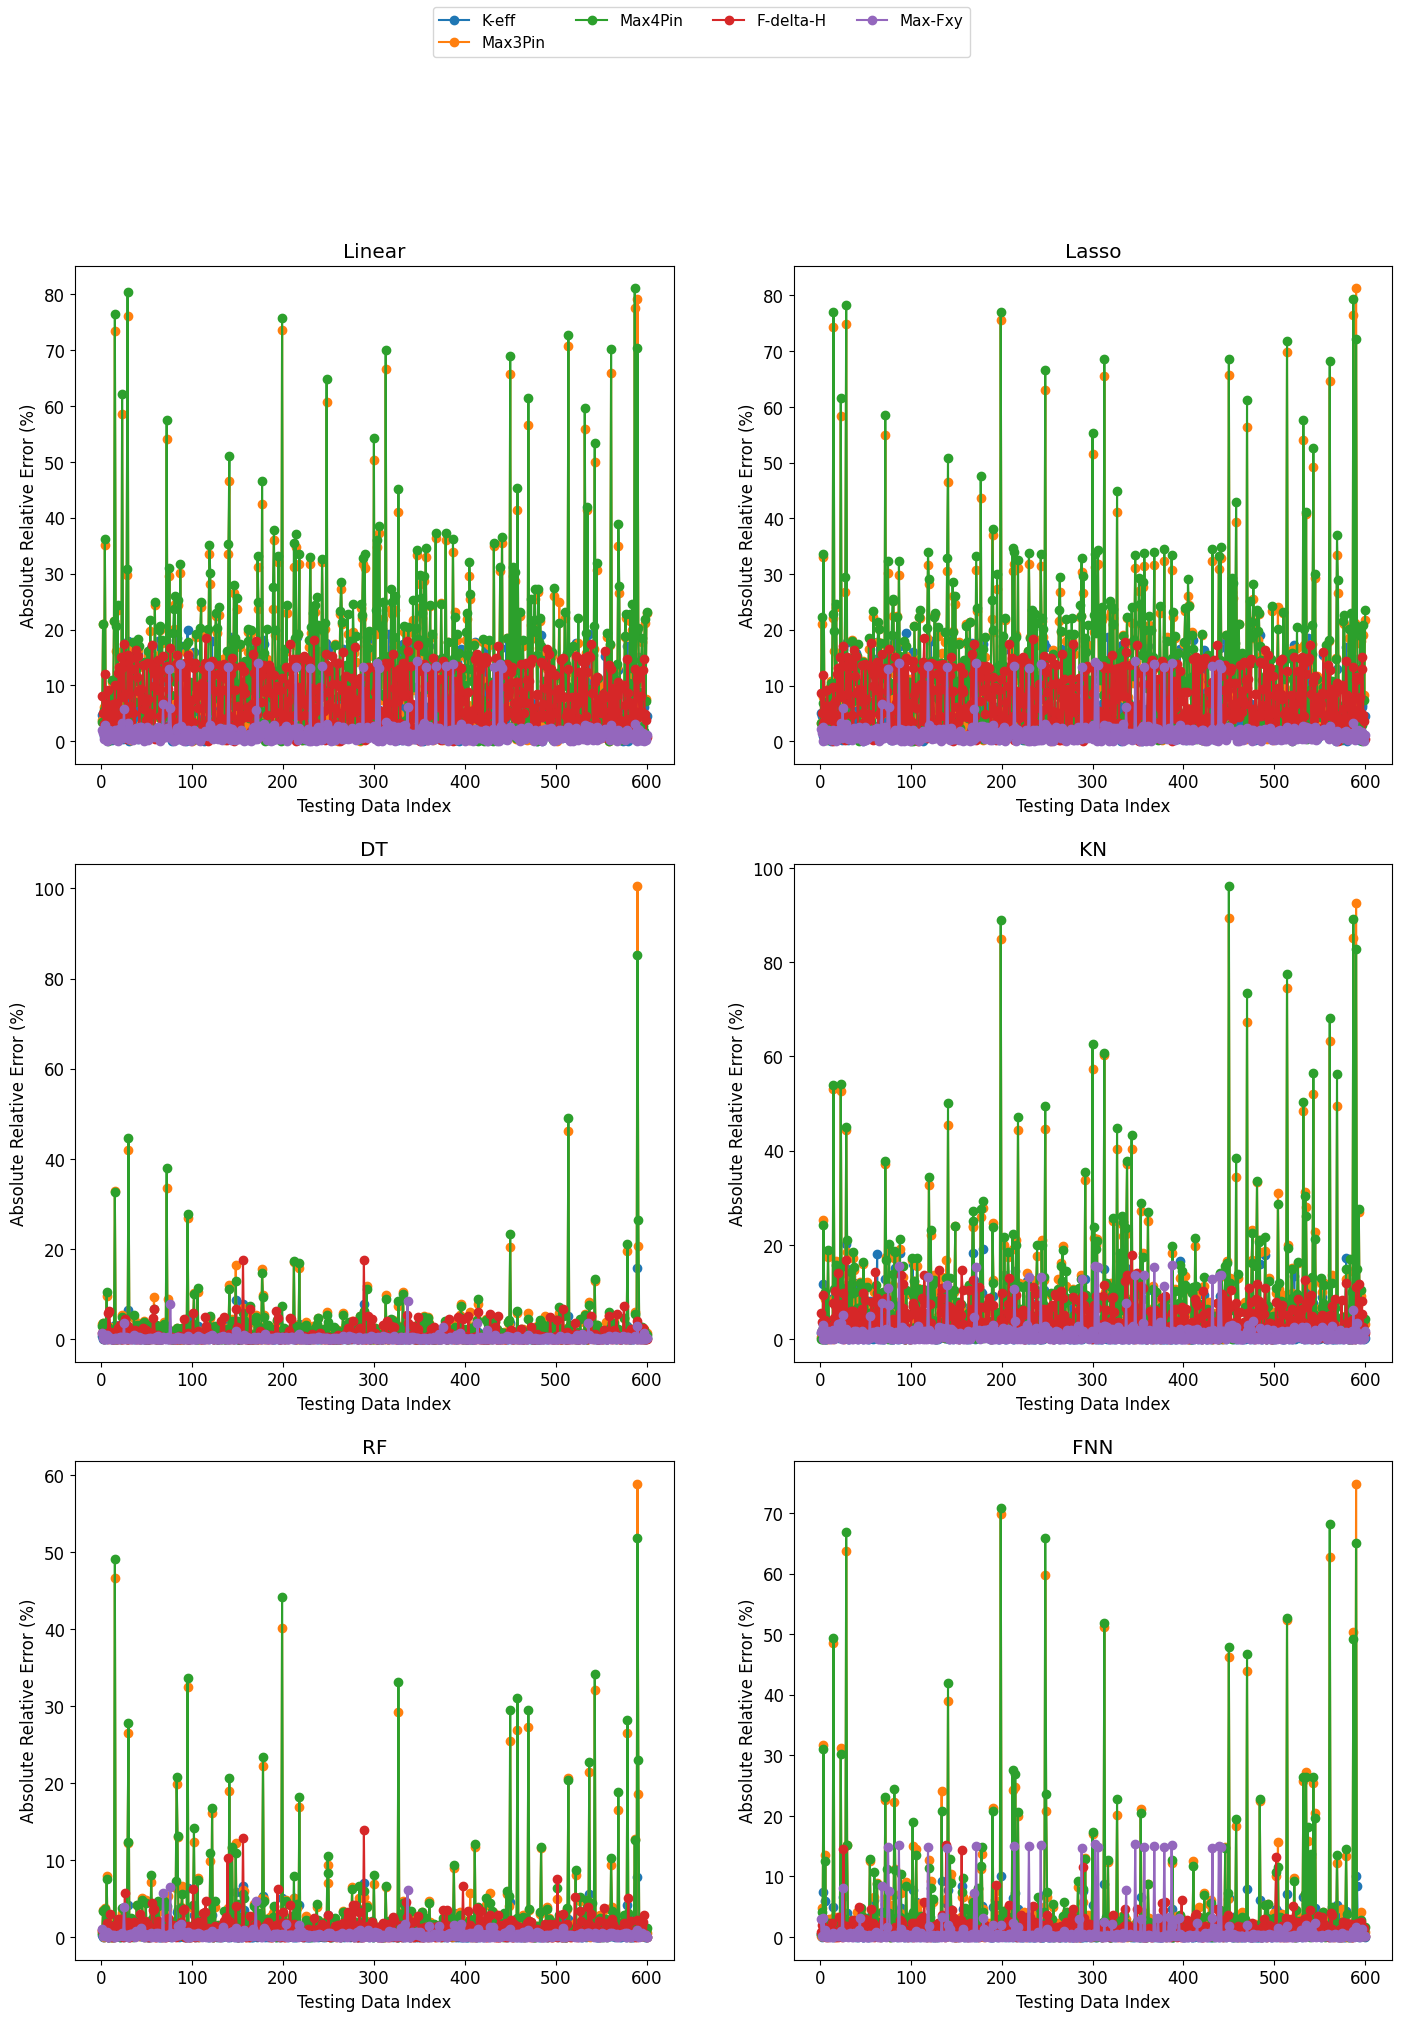

In [62]:
# Output Features and models to plot
y = ["K-eff", "Max3Pin", "Max4Pin", "F-delta-H", "Max-Fxy"]
models = np.array([["Linear", "Lasso"], ["DT", "KN"], ["RF", "FNN"]])

# Plot info
fig, axarr = plt.subplots(models.shape[0], models.shape[1], figsize=(17,22))

# Iterate and plot
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        plt.sca(axarr[i, j])
        axarr[i, j] = postprocessor.validation_plot(model_type=models[i, j], y=y)
        axarr[i, j].set_title(models[i, j])
        axarr[i, j].get_legend().remove()

fig.legend(y, loc="upper center", ncol=4)

The performance of the models is best represented by the magnitudes observed on the y-axis; however, even `RF` and `DT` get as high as $>3.0\%$ error. The biggest error can be seen from the output features `Max3Pin` and `Max4Pin`.

Finally, the learning curve of the most performant `nn` is shown by `nn_learning_plot`.

<AxesSubplot:xlabel='Epoch', ylabel='Loss'>

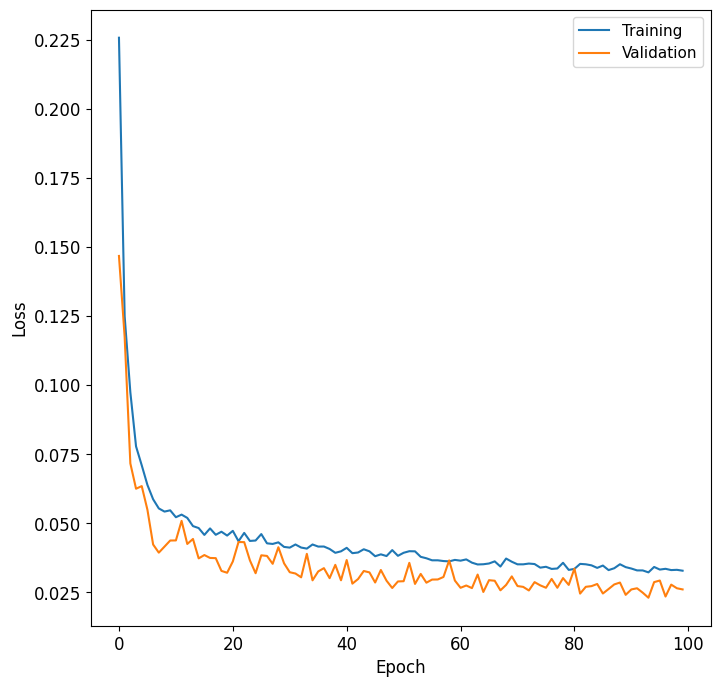

In [66]:
postprocessor.nn_learning_plot(model_type="FNN")

The neural network learning curve above shows that there is slight overfitting as training is slightly above validation. The difference between the loss curves is very small to the over fitting is not to impactful. The converges to 0.025 which is an acceptable number.

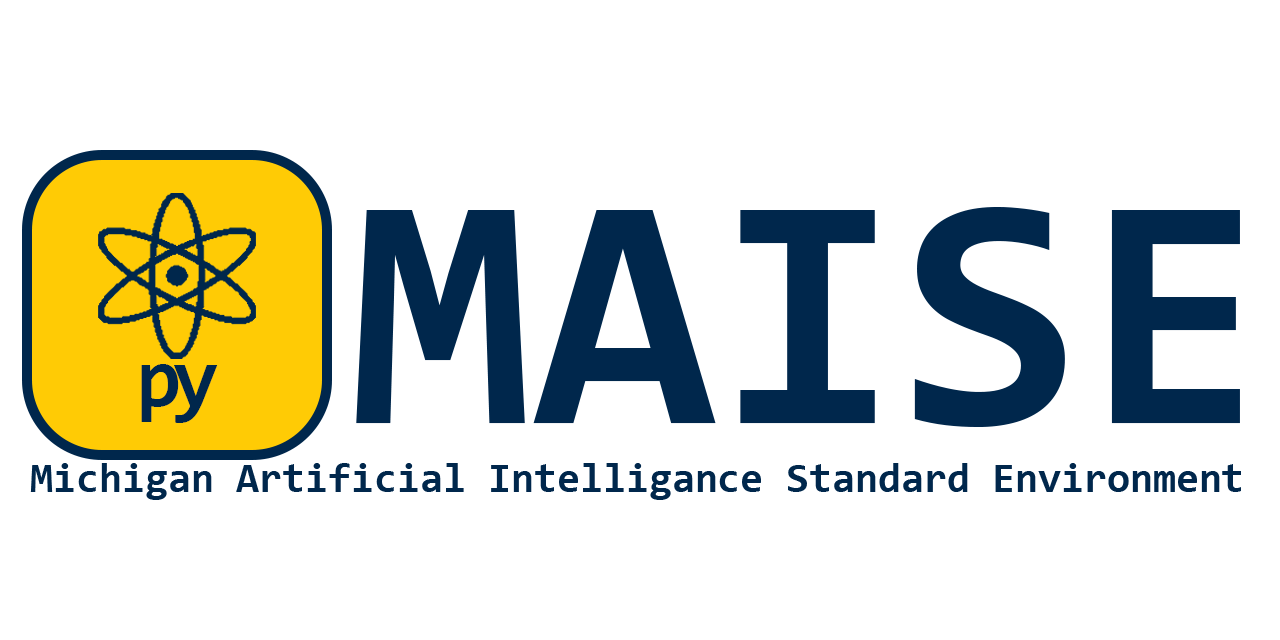